# OSIC: EDA + Leak-free KFold CV + LGB Baseline

## What is pulmanory fibrosis?

The word “pulmonary” means lung and the word “fibrosis” means **scar tissue**— similar to scars that you may have on your skin from an old injury or surgery. So, in its simplest sense, pulmonary fibrosis (PF) means **scarring in the lungs**. Over time, the scar tissue can destroy the normal lung and make it **hard for oxygen to get into your blood**. Low oxygen levels (and the stiff scar tissue itself) can cause you to feel short of breath, particularly when walking and exercising. Pulmonary fibrosis isn’t just one disease. It is a **family of more than 200 different lung diseases that all look very much alike**. The PF family of lung diseases falls into an even larger group of diseases called the **interstitial lung diseases** (also known as ILD), which includes all of the diseases that have inflammation and/or scarring in the lung. Some interstitial lung diseases don’t include scar tissue. **When an interstitial lung disease does include scar tissue in the lung, we call it pulmonary fibrosis.**

## Why is it important?

No one is certain how many people are affected by PF. One recent study estimated that idiopathic pulmonary fibrosis (or IPF, which is just one of more than 200 types of PF) affects 1 out of 200 adults over the age of 60 in the United States—that translates to more than 200,000 people living with PF today. Approximately 50,000 new cases are diagnosed each year and as many as 40,000 Americans die from IPF each year.

*From: https://www.pulmonaryfibrosis.org/life-with-pf/about-pf *

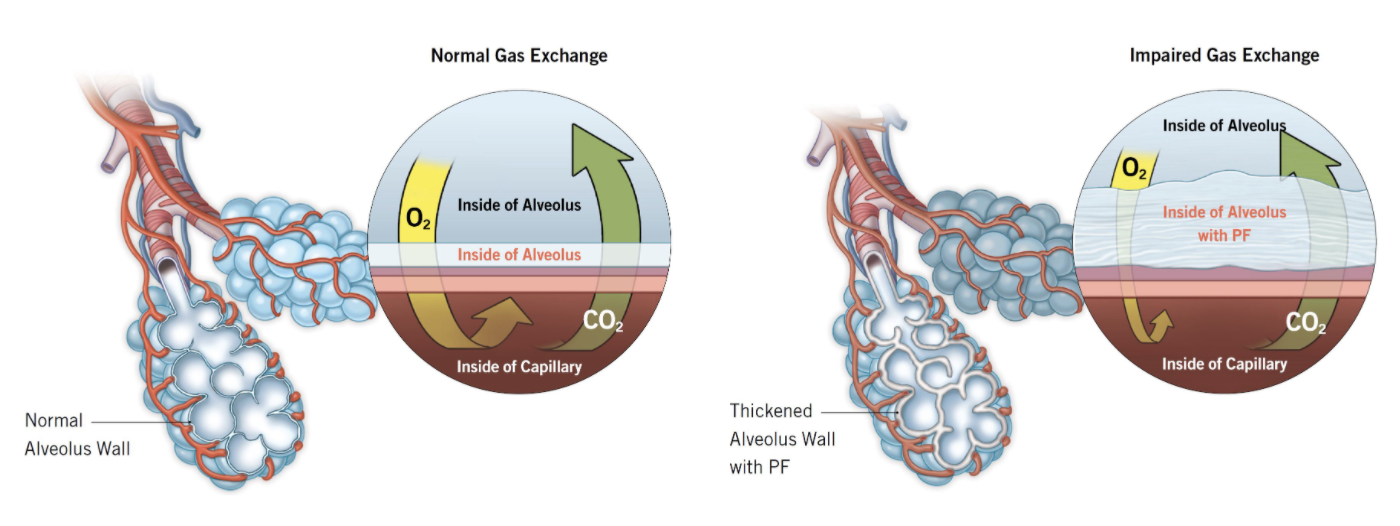

In [ ]:
from glob import glob

import statsmodels.api as sm

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import pydicom

import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

# EDA

## Getting familiar with tabular data

In [ ]:
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

train_df.head()

### Quick summary of available features

- Patient: unique ID of a patient
- Weeks: number of weeks pre or post the CT scan
- FVC (target): the lung capacity in ml, which measures the severity of the fibrosis
- Percent: a statistic which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
- Age: age
- Sex: sex
- SmokingStatus: is the patient an ex-smoker? a non-smoker? a current smoker?

In [ ]:
print('Number of training samples:', train_df.shape[0])
print('Number of test samples:', test_df.shape[0])

Interesting to note we only have 5 test samples, which means we'll have to build a robust validation strategy and to not rely too much on the leaderboard score.

### NaN values?

In [ ]:
print('Number of NaN values in training set:', int(train_df.isna().sum().sum()))
print('Number of NaN values in test set:', int(test_df.isna().sum().sum()))

No NaN values to handle, good news...

### Univariate analysis (distribution)

#### Patient id

One of the key thing we'll need to handle is to make sure we don't introduce any leaks in our folds. Put simply, if we divide the dataset into 5 folds of equal size, since multiple CT scans come from one patient, having CT scan A from Patient 1 in the training set and CT scan B from the same Patient 1 in the test set will introduce a data leak since the meta-features will be learnt by the statistical model at training time.

This would have the effect of artificially boost our performance, which is not something we want. Indeed, we want to have a true reflect of our model performance. Let's first investigate the distribution of number of pictures per patient.

Thanks to Twinkle Khanna for the plot, couldn't figure out how to do it with Seaborn ;)
https://www.kaggle.com/twinkle0705/your-starter-notebook-for-osic

In [ ]:
print('Number of unique patients:', len(train_df['Patient'].unique()))

In [ ]:
# Thanks to Twinkle Khanna for the plot, couldn't figure out how to do it with Seaborn ;)
# https://www.kaggle.com/twinkle0705/your-starter-notebook-for-osic

new_df = train_df.groupby(
    [
        train_df.Patient,
        train_df.Age,train_df.Sex, 
        train_df.SmokingStatus
    ]
)['Patient'].count()

new_df.index = new_df.index.set_names(
    [
        'id',
        'Age',
        'Sex',
        'SmokingStatus'
    ]
)

new_df = new_df.reset_index()
new_df.rename(columns = {'Patient': 'freq'},inplace = True)

fig = px.bar(new_df, x='id',y ='freq',color='freq')
fig.update_layout(
    xaxis={'categoryorder':'total ascending'},
    title='Distribution of images for each patient'
)
fig.update_xaxes(showticklabels=False)
fig.show()

Another good news, the distribution is almost uniform. No fat-tailed distributions which mean we don't have to worry about edge cases like a patient having 250 images and another one having only one. Our fold will be balanced and that's another great news for validation.

#### Weeks

In [ ]:
ax = sns.distplot(train_df['Weeks'], bins=100)
ax.set_title('Distribution of Weeks')

On the contrary of patient distribution, this one is heavy-tailed (in its simplest definition, its kurtosis is higher than 3). Most patients have their FVC measurements taken few weeks **AFTER** the baseline CT scan.

#### FVC (target value)

Now let's look at the target value, it is key to have a sense of what the empirical distribution is.

In [ ]:
ax = sns.distplot(train_df['FVC'], bins=100)
ax.set_title('Distribution of the target variable (FVC)')

In [ ]:
fig = px.histogram(
    train_df, 
    x='FVC',
    nbins =100
)

fig.update_traces(
    marker_color='rgb(158,202,225)', 
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, 
    opacity=0.6
)

fig.update_layout(
    title = 'Distribution of FVC'
)

fig.show()

The distribution looks Gaussian. After trying to apply different transforms (Box-Cox, Square Root, Log), the distribution doesn't change much. A possible experiment might be to try to predict the log or the square root of the target variable.

#### Age

In [ ]:
fig = px.histogram(
    new_df, 
    x='Age',
    nbins = 42
)

fig.update_traces(
    marker_color='rgb(158,202,225)', 
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, 
    opacity=0.6
)

fig.update_layout(
    title = 'Distribution of Age'
)

fig.show()

#### Sex

In [ ]:
temp = train_df.groupby('Sex').count()['Patient'].reset_index().sort_values(by='Patient',ascending=False)
temp.style.background_gradient(cmap='Reds')

In [ ]:
fig = px.funnel_area(
    names=temp['Sex'].values,
    values=temp['Patient'].values,
)

fig.update_layout(
    title = 'Distribution of Sex'
)

fig.show()

There are much more male samples than female samples. In a real-word, this might be a problem since the statistical model might be biased for female samples.

#### SmokingStatus

In [ ]:
temp = train_df.groupby('SmokingStatus').count()['Patient'].reset_index().sort_values(by='Patient',ascending=False)
temp.style.background_gradient(cmap='Reds')

In [ ]:
fig = px.funnel_area(
    names=temp['SmokingStatus'].values,
    values=temp['Patient'].values,
)

fig.update_layout(
    title = 'Distribution of SmokingStatus'
)

fig.show()

As expected, most patient having pulmonary fibrosis were ex-smokers since we know smoking is one of the leading factor in the development of a pulmonary fibrosis. The proportion of non-smoker people is non neglectable as well, while smokers only account for a small portion of the training set.

**Overall we'll need to make sure that the distribution of the features are identical in all the folds we generate.** Otherwise, we might unintendedly create folds that are easier than others.

### Bivariate analysis

#### Smoker status vs sex

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="SmokingStatus", hue="Sex", data=train_df)
for p in ax.patches:
    '''
    https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline
    '''
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
                height +3,
                '{:1.2f}%'.format(100*height/len(train_df)),
                ha="center")

ax.set_title('Bivariate analysis: Distribution of SmokingStatus with respect to Sex')

#### Sex vs Age

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.distplot(
    train_df[train_df['Sex'] == 'Male']['Age'], 
    bins=30, 
    ax=ax, 
    kde_kws=
        {
            "color": "blue", 
            "label": "Male"
        },
    hist_kws=
        {
            "linewidth": 3,
            "color": "blue"
        }
)

sns.distplot(
    train_df[train_df['Sex'] == 'Female']['Age'], 
    bins=30, 
    ax=ax,
    kde_kws=
        {
            "label": "Female",
            "color": 'mediumturquoise'
        },
    hist_kws=
        {
            'linewidth': 3,
            'color': 'mediumturquoise',
        }
)

fig.suptitle('Distribution of Age w.r.t. sex for unique patients')

In [ ]:
fig = px.histogram(
    train_df, 
    x='Age',
    color='Sex',
    color_discrete_map=
        {
            'Male':'blue',
            'Female':'mediumturquoise'
        },
    hover_data=train_df.columns
)

fig.update_layout(title='Distribution of Age w.r.t. sex for unique patients')

fig.update_traces(
    marker_line_color='black',
    marker_line_width=1.5, 
    opacity=0.85
)

fig.show()

At first glance, female distribution has the largest standard deviation and a higher kurtosis (more females have an age in the tails) than the male distribution. Male distribution has a higher peak suggesting that male ages are more concentrated around the mean.

#### Smoker vs Age

In [ ]:
# Plot overlapping distribution

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.distplot(
    train_df[train_df['SmokingStatus'] == 'Never smoked']['Age'], 
    bins=30, 
    ax=ax, 
    kde_kws=
        {
            "color": "khaki", 
            "label": "Never smoked"
        },
    hist_kws=
        {
            "linewidth": 3,
            "color": "khaki"
        }
)

sns.distplot(
    train_df[train_df['SmokingStatus'] == 'Currently smokes']['Age'], 
    bins=30, 
    ax=ax,
    kde_kws=
        {
            "label": "Currently smokes",
            "color": 'darksalmon'
        },
    hist_kws=
        {
            'linewidth': 3,
            'color': 'darksalmon',
        }
)

sns.distplot(
    train_df[train_df['SmokingStatus'] == 'Ex-smoker']['Age'], 
    bins=30, 
    ax=ax,
    kde_kws=
        {
            "label": "Ex-smoker",
            "color": 'teal'
        },
    hist_kws=
        {
            'linewidth': 3,
            'color': 'teal',
        }
)

fig.suptitle('Distribution of Age w.r.t. SmokingStatus for unique patients')

In [ ]:
fig = px.histogram(
    train_df, 
    x='Age',
    color='SmokingStatus',
    color_discrete_map=
        {
            'Never smoked':'khaki',
            'Currently smokes':'darksalmon',
            'Ex-smoker': 'teal', 
        },
    hover_data=train_df.columns
)

fig.update_layout(title='Distribution of Age w.r.t. SmokingStatus for unique patients')

fig.update_traces(
    marker_line_color='black',
    marker_line_width=1.5, 
    opacity=0.85
)

fig.show()

**Some notes**:
- The age distribution of people currently smoking has multiple peaks and is discontinuous. It is not concentrated around a mean and is equally distributed between 50 and 70 year-old.
- As expected, the ex-smoker are often older than the people who have never smoked. The standard deviation is equivalent between the two.

#### FVC vs sex

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.distplot(
    train_df[train_df['Sex'] == 'Male']['FVC'], 
    bins=30, 
    ax=ax, 
    kde_kws=
        {
            "color": "blue", 
            "label": "Male"
        },
    hist_kws=
        {
            "linewidth": 3,
            "color": "blue"
        }
)

sns.distplot(
    train_df[train_df['Sex'] == 'Female']['FVC'], 
    bins=30, 
    ax=ax,
    kde_kws=
        {
            "label": "Female",
            "color": 'mediumturquoise'
        },
    hist_kws=
        {
            'linewidth': 3,
            'color': 'mediumturquoise',
        }
)

fig.suptitle('Distribution of FVC w.r.t. sex for unique patients')

In [ ]:
fig = px.histogram(
    train_df, 
    x='FVC',
    color='Sex',
    color_discrete_map=
        {
            'Male':'blue',
            'Female':'mediumturquoise'
        },
    hover_data=train_df.columns
)

fig.update_layout(title='Distribution of FVC w.r.t. sex for unique patients')

fig.update_traces(
    marker_line_color='black',
    marker_line_width=1.5, 
    opacity=0.85
)

fig.show()

As expected, since the lung capacity of male is often larger than female, the distribution of FVC is shifted to the right.

#### FVC vs smoker

In [ ]:
# Plot overlapping distribution

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.distplot(
    train_df[train_df['SmokingStatus'] == 'Never smoked']['FVC'], 
    bins=30, 
    ax=ax, 
    kde_kws=
        {
            "color": "khaki", 
            "label": "Never smoked"
        },
    hist_kws=
        {
            "linewidth": 3,
            "color": "khaki"
        }
)

sns.distplot(
    train_df[train_df['SmokingStatus'] == 'Currently smokes']['FVC'], 
    bins=30, 
    ax=ax,
    kde_kws=
        {
            "label": "Currently smokes",
            "color": 'darksalmon'
        },
    hist_kws=
        {
            'linewidth': 3,
            'color': 'darksalmon',
        }
)

sns.distplot(
    train_df[train_df['SmokingStatus'] == 'Ex-smoker']['FVC'], 
    bins=30, 
    ax=ax,
    kde_kws=
        {
            "label": "Ex-smoker",
            "color": 'teal'
        },
    hist_kws=
        {
            'linewidth': 3,
            'color': 'teal',
        }
)

fig.suptitle('Distribution of FVC w.r.t. SmokingStatus for unique patients')

In [ ]:
fig = px.histogram(
    train_df, 
    x='FVC',
    color='SmokingStatus',
    color_discrete_map=
        {
            'Never smoked':'khaki',
            'Currently smokes':'darksalmon',
            'Ex-smoker': 'teal', 
        },
    hover_data=train_df.columns
)

fig.update_layout(title='Distribution of FVC w.r.t. SmokingStatus for unique patients')

fig.update_traces(
    marker_line_color='black',
    marker_line_width=1.5, 
    opacity=0.85
)

fig.show()

The "Currently Smokes" distribution is more peaked around 2700ml.

**Now let's plot continuous variables against the target.**

#### Weeks vs FVC

In [ ]:
sns.jointplot(x="Weeks", y="FVC", data=train_df)

At first sight, it doesn't seem like there's a clear correlation between the number of Weeks before or after the baseline CT scan and the FVC. We need to be careful if we want to apply an ordinary least-square regression because all the hypotheses of the model are not respected.

In particular, it seems like the data is heretoskedastic which can make the OLS fail or give inexact results because of the failing of the least-square method. Let's try to do a quick regression.

In [ ]:
X = train_df['Weeks'].values
y = train_df['FVC'].values

results = sm.OLS(y, X).fit()
print(results.summary())

The Adjusted R-squared is **0.584**, which indicates that a significant part of the variance of FVC is explained by Weeks. That is corroborated by the fact the Omnibus test indicates that the explained variance is way higher than the unexplained variance. 

However this number should be carefully interpreted since as stated above the hypotheses of the statistical model might not be all respected. It could thus lead to an overestimation of the R-squared ratio. In particular, the Durbin-Watson statistics which is a measure of the auto-correlation of data is particularly close to 0, which indicates a positive autocorrelation.

Intuitively though, we could think that the more weeks after the CT baseline, the more the lung capacity worsens and thus the less the FVC.

Let's try to investigate a bit further to see if at the patient-level, the lung capacity declines over the weeks.

In [ ]:
def plot_patient_level_weeks_vs_fvc(patient_id, ax):
    X = train_df[train_df['Patient'] == patient_id]['Weeks'].values
    y = train_df[train_df['Patient'] == patient_id]['FVC'].values
    
    ax.set_title(patient_id)
    ax = sns.regplot(X, y, ax=ax, ci=None, line_kws={'color':'red'})

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))

patient_ids = train_df["Patient"].sample(n=3).values

for i in range(3):
    plot_patient_level_weeks_vs_fvc(patient_ids[i], axes[i])

Indeed, we find that as the number of weeks increases, the lung capacity worsens... There are some feature engineering to do: running average of the lung capacity, previous max, previous min...

#### Percent vs FVC

In [ ]:
sns.jointplot(x="Percent", y="FVC", data=train_df)

This plot indicates a strong correlation between Percent and FVC. Again, there might have an heteroskedasticity issue.

In [ ]:
X = train_df['Percent'].values
y = train_df['FVC'].values

results = sm.OLS(y, X).fit()
print(results.summary())

#### Visualizing images

Now let's try to visualize the DICOM images to gain a sense of what a CT scan looks like and how we can load a CT scan in a model.

In [ ]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

TBC....

# Generating leak-free folds

Now that we have a clear idea of what our data looks like. We need to build a robust validation strategy. Since there exist only 5 samples in the test set, we want to rely on an accurate validation score to make decisions.
In particular, we don't want to include any leak as explained higher in the notebook. We don't want one patient being in the training folds and the validation fold at the same time since the statistical model might have learnt the features of a patient. Our validation fold would not be an accurate test of whether our model is able to generalize.

Hence, let's try to use GroupKFold to create a K-fold partition with non-overlapping groups (here the Patient ID).

In [ ]:
gkf = GroupKFold(n_splits=5)

X = train_df[['Patient', 'Weeks', 'Percent', 'Age', 'Sex', 'SmokingStatus']].values
y = train_df['FVC'].values
groups = train_df['Patient'].values

for i, (trn_, val_) in enumerate(gkf.split(X, y, groups)):
    train_df.loc[val_, 'fold'] = i

train_df['fold'] = train_df['fold'].astype(int)

In [ ]:
p = []

for i in range(5):
    f = set(train_df[train_df['fold'] == i]['Patient'].unique())
    p.append(f)

print('Number of common patients across folds:', len(set.intersection(*p)))

In [ ]:
# Check distribution of patients within a fold

fig, ax = plt.subplots(1, 5, figsize=(18, 3))

for i in range(5):
    sns.countplot(train_df[train_df['fold'] == i]['Patient'], ax=ax[i])
    ax[i].set_title(f'Fold {i+1}')
    ax[i].xaxis.set_ticklabels([])

fig.suptitle('Distribution of patients in folds')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
train_df.head()

In [ ]:
train_df.to_csv('train_df.csv')

As you can see, no overlapping groups and the distribution of patients across the folds is close to being uniform and identical which is what we want. 

Now let's try to build a baseline model ;)

# Baseline model (Meta-features only)

In [ ]:
# Quick label encoding

le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])

train_df['SmokingStatus'] = le.fit_transform(train_df['SmokingStatus'])
test_df['SmokingStatus'] = le.transform(test_df['SmokingStatus'])

In [ ]:
def metric(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
        Calculates the modified Laplace Log Likelihood score for this competition.
        Credits: https://www.kaggle.com/rohanrao/osic-understanding-laplace-log-likelihood
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)

In [ ]:
param = {
        'objective':'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'max_depth':-1
}

target = 'FVC'

In [ ]:
def train_lgb_model(features):    
    y_oof = np.zeros(train_df.shape[0])
    y_test = np.zeros((test_df.shape[0], 5))

    for f, (train_ind, val_ind) in enumerate(gkf.split(train_df, train_df, groups)):
        print(f'Training on all folds except {f}, validation on {f}')
        t_df, val_df = train_df.iloc[train_ind], train_df.iloc[val_ind]

        model = LGBMRegressor()
        model.fit(t_df[features], t_df[target])
        
        lgb.plot_importance(model, title=f'Feature importance - Fold {f+1}')

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
    
    return y_oof, y_test

In [ ]:
features = ['Weeks', 'Percent', 'Age', 'Sex', 'SmokingStatus']
y_oof, y_test = train_lgb_model(features)

In [ ]:
train_df['oof_preds'] = y_oof
test_df['target'] = y_test.mean(axis=1)

score = metric(train_df[target], train_df['oof_preds'], np.std(train_df['oof_preds']))

print('OOF log-Laplace likelihood score:', score)

After a quick training, we obtain a baseline meta-features-only score of **-7.504558251812265**. We can improve this score with further feature engineering as we shall see later.

### Feature engineering

In [ ]:
# Lagging features

def generate_lagging_features(df):
    for i in [1, 2, 3]:
        df['lag_FVC_'+str(i)] = df.groupby(['Patient'])['FVC'].transform(lambda x: x.shift(i))
        df['lag_percent_'+str(i)] = df.groupby(['Patient'])['Percent'].transform(lambda x: x.shift(i))
    
    return df

In [ ]:
# Running statistics

def generate_running_statistics(df):
    for i in [3, 5, 7]:
        df['rolling_FVC_mean_'+str(i)] = df.groupby(['Patient'])['FVC'].transform(lambda x: x.shift(1).rolling(i).mean())
        df['rolling_FVC_std_'+str(i)]  = df.groupby(['Patient'])['FVC'].transform(lambda x: x.shift(1).rolling(i).std())
        df['rolling_FVC_max_'+str(i)]  = df.groupby(['Patient'])['FVC'].transform(lambda x: x.shift(1).rolling(i).max())
        
        df['rolling_percent_mean_'+str(i)] = df.groupby(['Patient'])['Percent'].transform(lambda x: x.shift(1).rolling(i).mean())
        df['rolling_percent_std_'+str(i)]  = df.groupby(['Patient'])['Percent'].transform(lambda x: x.shift(1).rolling(i).std())
        df['rolling_percent_max_'+str(i)]  = df.groupby(['Patient'])['Percent'].transform(lambda x: x.shift(1).rolling(i).max())
    
    return df

In [ ]:
train_df = generate_lagging_features(train_df)
train_df = generate_running_statistics(train_df)

test_df = generate_lagging_features(test_df)
test_df = generate_running_statistics(test_df)

In [ ]:
features = [x for x in list(train_df.columns) if x not in ['Patient', 'fold', 'FVC', 'oof_preds']]
y_oof, y_test = train_lgb_model(features)

In [ ]:
train_df['oof_preds'] = y_oof
test_df['target'] = y_test.mean(axis=1)

score = metric(train_df[target], train_df['oof_preds'], np.std(train_df['oof_preds']))

print('OOF log-Laplace likelihood score:', score)

With feature engineering, our score is now **-7.211202141267011**, which is an improvement of our CV!

Thanks for reading, if you like the notebook, don't forget to upvote ;)